In this notebook, I extract the broadband flux time series as well as the spectrophometric time series (i.e. the raw transmission spectrum) from our HST data. 

In [1]:
# Importing modules we need:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.convolution as ac
from astropy.io import fits
from scipy.interpolate import interp1d
# Importing HST extraction functions
#import HST_Extract_Funcs as hst
import HST_extraction as ext

['/home/mmmurphy/inquiry/hd219666b/reduction', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/mmmurphy/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/mmmurphy/anaconda3/lib/python3.8/site-packages']


I've placed the data in a separate directory off my home directory. Thomas' file structure that loads in the data, however, needs the data held in a directory that branches from the present working directory. Therefore, I'll need to edit this file structure to find where I've placed the data.

If the below block of code is commented out, then I've already done this so skip to next block to load in the new file path structure

In [2]:
# # Load in Thomas' file structure
# FSload = np.load('FilePaths.npz', allow_pickle=True)
# data_dict = FSload['filedict'].item()   # dictionary containing paths to the image files

# # Make a deep copy that I can edit
# import copy
# ddcopy = copy.deepcopy(data_dict)
# # Now to edit the paths within the copy dictionary
# for visit in data_dict:
#     # Go through each visit
#     for orbit in data_dict[visit]:
#         # Go through each orbit in that visit
#         #
#         # Each orbit has only one direct image
#         # First, edit this direct image's path
#         oldpath = data_dict[visit][orbit]['direct']
#         newpath = oldpath.replace('/home/matthew/data/hd219666b/hst_images/', '/home/mmmurphy/data/hd219666b/hst_images/')
#         ddcopy[visit][orbit]['direct'] = newpath
#         # Now looping through this orbit's grism images and editing their paths
#         grismpaths = data_dict[visit][orbit]['grism']
#         for i, oldpath in enumerate(grismpaths):
#             newpath = oldpath.replace('/home/matthew/data/hd219666b/hst_images/', '/home/mmmurphy/data/hd219666b/hst_images/')
#             ddcopy[visit][orbit]['grism'][i] = newpath
            
# # Saving this edited dictionary as the new file structure dictionary
# np.savez('FilePaths.npz', filedict=ddcopy)

Loading in the dictionary containing the file paths to our data

In [3]:
FPload = np.load('FilePaths.npz', allow_pickle=True)
datapaths = FPload['filedict'].item()   # dictionary containing paths to the image files

In [4]:
def apply_fixes(spectra, orbit, image):
    if orbit == 'orbit3':
        if image == 1:
            spectra[11, 13, 113] = np.median([spectra[11, 13, 112], spectra[11, 13, 114]])
            spectra[11, 14, 113] = np.median([spectra[11, 14, 112], spectra[11, 14, 115]])
            spectra[11, 14, 114] = np.median([spectra[11, 14, 113], spectra[11, 14, 115]])
        elif image == 4:
            spectra[7, 11, 86] = np.median([spectra[7,11,85], spectra[7,11,87]])
        elif image == 5:
            spectra[9,18,99] = np.median([spectra[9,18,98], spectra[9,18,100]])
        elif image == 13:
            spectra[10,12, 25:150] = np.median([spectra[10,11,25:150], spectra[10,11,25:150]], axis=0)
        elif image==14:
            spectra[8,11,157] = np.median([spectra[8,11,155], spectra[8,11,158]])
        elif image==15:
            spectra[10,11,107] = np.median([spectra[10,11,106], spectra[10,11,108]])
            spectra[10,12,107] = np.median([spectra[10,12,106], spectra[10,12,108]])
            
    return spectra

In [5]:
def binspectrum(pixel_axis, spectrum, Nbins):
    
    bin_edges = np.linspace(pixel_axis[0], pixel_axis[-1], Nbins, endpoint=True)
    #print(bin_edges)
    bin_identities = np.digitize(pixel_axis, bin_edges) - 1
    #print(bin_identities)
    
    spectrum_binned = np.zeros(Nbins)
    i = 0
    while i <= (Nbins - 1):
        bin_member_idxs = np.where(bin_identities == i)[0]
        member_specvals = spectrum[bin_member_idxs]
        bin_specval = np.median(member_specvals)
        spectrum_binned[i] = bin_specval
        
        i += 1
    
    return bin_edges, spectrum_binned
    

In [19]:
for orbit in datapaths['visit3']:
    # Going through each orbit in the visit
    #    reminder: we're only using visit 3's data
    if orbit != 'orbit3':
        #continue
        ...
    print('On orbit ', orbit)
    
    ######################################################
    # STEP 1 - Load in the direct image for this orbit
    #          and compute the wavelength solution
    direct_image_path = datapaths['visit3'][orbit]['direct']
    # compute the parameters of the wavelength solution:
    wavesolution = ext.WavelengthSolution(direct_image_path) 
    # find the start & end values of the pixel range over which our spectrum is placed on the image
    min_wavelength = 9708   # Min wavelength of response function, [Angstrom]
    max_wavelength = 17904
    extractrange = ext.GetExtractRange(min_wavelength, max_wavelength, direct_image_path, 0)
    
    ######################################################
    # STEP 2 - Go through each grism exposure in this orbit
    # Creating some arrays to contain the data of each grism exposure
    Nimages = len(datapaths['visit3'][orbit]['grism'])
    orbit_1Dspectra = [ [] for _ in range(Nimages)]        # 1D spectra of each image
    orbit_1Dspectra_uncs = [ [] for _ in range(Nimages)]   # 1D spectral errors of each image
    orbit_broadbands = np.zeros(Nimages)                   # Band-integrated flux of each image
    orbit_broadbands_uncs = np.zeros(Nimages)              # Band-integrated flux error of each image
    orbit_times = np.zeros(Nimages)
    orbit_spectral_xlimits = np.zeros((Nimages, 2))        # left and right-most x-values of extracted spectra to use for wavelength calibration
    for image in range(Nimages):
        if image != 0:
            #continue
            ...
        print('Working on image ',image)
        
        ###################################################
        # STEP 3 - Separate out each sub-exposure within this image
        subexp_details = ext.CreateSubExps(datapaths['visit3'][orbit]['grism'][image], wavesolution)
        subexp_images = subexp_details[0]        # Array containing each sub-exposure's image array
        subexp_times = subexp_details[1]         # Array containing the time of each sub exposure [BJD TDB]
        subexp_badpixmasks = subexp_details[2]   # Array containing each sub-exposure's bad pixel mask
        subexp_dataqualities = subexp_details[3] # Array containing DQ flags on each sub-exposure
        subexp_scandirs = subexp_details[4]      # Array containing the scan direction of each sub-exposure
        subexp_shifts = subexp_details[6]        # Array containing angular shifting of each sub-exposure
        Nsubexps = subexp_images.shape[0]        # Number of sub-exposures in this image
        
        if orbit=='orbit4':
            if image==3:
                subexp_images[5, 150:200, 320:380] = 0.
        
        
        orbit_times[image] = np.median(subexp_times)
        
        ###################################################
        # STEP 4 - Subtract out the background flux on each sub-exposure image
        bksub_details = ext.BkgdSub(subexp_images, subexp_badpixmasks, subexp_scandirs)
        bsub_subexp_images = bksub_details[0]  # each background subtracted sub-exposure image
        bsub_subexp_bkvals = bksub_details[1]  # background values of each sub-exposure
        bsub_subexp_bkerrs = bksub_details[2]  # uncertainty on above
        
        ###################################################
        # STEP 5 - Flat-field each background subtracted sub-exposure image
        # Path to the appropriate flat-field calibration image:
        flatimg = '/home/mmmurphy/data/hd219666b/calibrations/WFC3.IR.G141.flat.2.fits'
        flat_subexp_images = ext.FlatField(flatimg, bsub_subexp_images, wavesolution, subexp_shifts)
        
        
        ###################################################
        # STEP 6a - Extract the 2D target spectrum
        if (orbit=='orbit2') and (image==13):
            twoDspectra, boxCoords = ext.cutout2Dspectrum(flat_subexp_images, extractrange, 15, 5, returnCoords=True, manualOverride='o2i13')
        else:
            twoDspectra, boxCoords = ext.cutout2Dspectrum(flat_subexp_images, extractrange, 15, 5, returnCoords=True)
            
        orbit_spectral_xlimits[image][0] = boxCoords[0][2] 
        orbit_spectral_xlimits[image][1] = boxCoords[0][3] # using just the first sub-exposure, since it's unshifted and we shift others to it
        
#         plt.imshow(twoDspectra[6], origin='lower')
#         plt.title('Flatted 2D spectrum, pre-BP correction')
#         plt.show()
        
        # STEP 6b - Extract the 2D data quality array
        DQspectra = np.zeros(twoDspectra.shape)
        for i in range(DQspectra.shape[0]):
            coords = boxCoords[i]
            DQspectra[i] = subexp_dataqualities[i, coords[0]:coords[1], coords[2]:coords[3]]

        ###################################################
        # Step 7 - Bad pixel correction
        twoDspectra_corr = ext.CorrectBadPixels(twoDspectra, DQspectra, Niter=5)
        twoDspectra_corr = apply_fixes(twoDspectra_corr, orbit, image)
             
        ##################################################
        # STEP 8 - Fitting the spectral trace
        disp_axis, traces = ext.FitSpectralTrace(twoDspectra_corr)

 
#         for i in range(twoDspectra_corr.shape[0]):
#             plt.imshow(twoDspectra_corr[i], origin='lower', vmin=0)
#             plt.plot(disp_axis, traces[i], c='red')
# #                 if i==10:
# #                     #plt.scatter(107, 12, marker='o', s=3, facecolor='None', edgecolor='red')
# #                     #plt.scatter(107, 11, marker='o', s=5, facecolor='None', edgecolor='red')
# #                     ...
#             plt.colorbar()
#             plt.title('BP corrected 2D spectrum for subexp %d, image %d'%(i, image))
#             plt.show()
        
        
        ##################################################
        # Step 9 - Extracting the 1D spectra
        oneDspectra, oneDerrors = ext.Extract1D(twoDspectra_corr, traces, extractionheight=14)

        
        #####################################################
        # STEP 10 - Cross-correlating the sub-exposure 1D spectra to correct for shifting
        min_shift = min(subexp_shifts[np.where(subexp_shifts > 0.)[0]]) # minimum shift determined from scan angles, will set the resolution of our interpolation
        x_uninterp = np.arange(len(oneDspectra[0]))
        x_interp = np.arange(x_uninterp[0], x_uninterp[-1], min_shift)
        interp_1Dspectra = np.zeros((oneDspectra.shape[0], len(x_interp)))
        for subexp in range(oneDspectra.shape[0]):
            # Create the interpolation function based on the observed, native resolution spectrum
            interp_1Dspectrum_subexp = interp1d(x=np.arange(len(oneDspectra[subexp])), y=oneDspectra[subexp], kind='quadratic')
            # interpolate to finer x_axis, based on minimum estimated shift
            subexp_interpolatedspectrum = interp_1Dspectrum_subexp(x_interp)
            # determine this subexposure's shift, in units of the new x-axis' spacing
            shiftsize = int(np.rint(subexp_shifts[subexp] / min_shift ))
            if (image+1)%2 == 0:
                #shiftsize = -shiftsize # note: commented this out to test
                ...
            # shift this subexposure's interpoalted spectrum
            shifted_subexp_interpolatedspectrum = ext.shift(subexp_interpolatedspectrum, -shiftsize, yzerolevel=10000.) 
            # now resample the interpolated spectrum back to the native resolution
            resampled_shifted_subexpspectrum = binspectrum(x_interp, shifted_subexp_interpolatedspectrum, len(oneDspectra[0]))[1]          
#             plt.plot(x_uninterp, oneDspectra[subexp], c='black')
#             plt.plot(x_uninterp, resampled_shifted_subexpspectrum, c='orange')
#             plt.show()
            # re-assigning the spectrum
            oneDspectra[subexp] = np.copy(resampled_shifted_subexpspectrum)

                
#         for i in range(oneDspectra.shape[0]):
#             y = oneDspectra[i]
#             x = np.arange(len(y))
#             plt.plot(x, y, label='subexp %d'%(i))
#         plt.legend(loc='best', fontsize=7)
#         plt.title('Subexp 1D spectra, pre-CC')
#         plt.show()
        
        ####################################################
        # STEP 11 - Combining the 1D spectra subexposures into the image 1D spectrum
        # we'll do this just by summing the shift-corrected spectra at each dispersion pixel
        # since they've been shifted already, the dispersion pixels should already line up
        # so sum axis = the N subexposure axis
        oneDspectrum_img = np.sum(oneDspectra, axis=0)
        temp_sqr = oneDspectra#**2
        oneDerror_img = np.sqrt(np.sum(temp_sqr, axis=0))
        del temp_sqr
        
        orbit_1Dspectra[image] = np.copy(oneDspectrum_img)
        orbit_1Dspectra_uncs[image] = np.copy(oneDerror_img)
        
        #######################################################
        # STEP 12 - Getting the image broadband flux value
        broadband_img = np.sum(oneDspectrum_img)
        temp_sqr2 = oneDspectrum_img#**2
        broaderr_img = np.sqrt(np.sum(temp_sqr2))
        del temp_sqr2
        
        
        orbit_broadbands[image] = broadband_img                 # Band-integrated flux of each image
        orbit_broadbands_uncs[image] = broaderr_img
        
    orbit_1Dspectra = np.asarray(orbit_1Dspectra)
    orbit_1Dspectra_uncs = np.asarray(orbit_1Dspectra_uncs)
        
#     ######################
#     # STEP 12 - Cross-correlate the image 1D spectra in each orbit
#     #min_shift = min(subexp_shifts[np.where(subexp_shifts > 0.)[0]]) # minimum shift determined from scan angles, will set the resolution of our interpolation
#     x_uninterp = np.arange(len(orbit_1Dspectra[0]))
#     x_interp = np.arange(x_uninterp[0], x_uninterp[-1], min_shift)
#     interp_1Dspectra = np.zeros((orbit_1Dspectra.shape[0], len(x_interp)))
#     for img in range(interp_1Dspectra.shape[0]):
#         # Create the interpolation function based on the observed, native resolution spectrum
#         interp_1Dspectrum_img = interp1d(x=np.arange(len(orbit_1Dspectra[img])), y=orbit_1Dspectra[img], kind='quadratic')
#         # interpolate to finer x_axis, based on minimum estimated shift
#         img_interpolatedspectrum = interp_1Dspectrum_img(x_interp)
#         # determine this subexposure's shift, in units of the new x-axis' spacing
#         shiftsize = int(np.rint(subexp_shifts[subexp] / min_shift )) #### WHAT TO DO HERE WITHOUT IMAGE SHIFTS
#         if (image+1)%2 == 0:
#             shiftsize = -shiftsize
#         # shift this subexposure's interpoalted spectrum
#         shifted_subexp_interpolatedspectrum = ext.shift(subexp_interpolatedspectrum, -shiftsize, yzerolevel=10000.)
#         # now resample the interpolated spectrum back to the native resolution
#         resampled_shifted_subexpspectrum = binspectrum(x_interp, shifted_subexp_interpolatedspectrum, len(oneDspectra[0]))[1]          
#     #             plt.plot(x_uninterp, oneDspectra[subexp], c='black')
#     #             plt.plot(x_uninterp, resampled_shifted_subexpspectrum, c='orange')
#     #             plt.show()
#         # re-assigning the spectrum
#         oneDspectra[subexp] = np.copy(resampled_shifted_subexpspectrum)


    image_1Dspecshifts = np.zeros(orbit_1Dspectra.shape[0], dtype=int)
    for i in range(orbit_1Dspectra.shape[0]):
        if i == 0:
            continue
        # we assume the first one is correct
        # finding the shift
        spec_shift = ext.crosscorrelate(orbit_1Dspectra[0], orbit_1Dspectra[i], guesslimits=5, yzerolevel=500000.)[0]
        image_1Dspecshifts[i] = spec_shift

    # if there were shifts, here we correct them
    # we'll do this recursively until no shifts are detected
    shift_checks = np.copy(image_1Dspecshifts)
    while len(np.where(shift_checks != 0)[0]) != 0:
        toshift_idxs = np.where(image_1Dspecshifts != 0)[0]
        for idx in toshift_idxs:
            # un-shifting it
            orbit_1Dspectra[idx] = ext.shift(orbit_1Dspectra[idx], -image_1Dspecshifts[idx], 
                                          yzerolevel=500000.)
            # checking the new shift
            # if it's non-zero, this spectrum will go through the loop again
            shift_checks[idx] = ext.crosscorrelate(orbit_1Dspectra[0], orbit_1Dspectra[idx], guesslimits=5, yzerolevel=100000.)
    
        
    # Now to save things
    if orbit == 'orbit1':
        orbit1_1Dspectra = np.copy(orbit_1Dspectra)
        orbit1_1Dspectrauncs = np.copy(orbit_1Dspectra_uncs)
        orbit1_broadbands = np.copy(orbit_broadbands)
        orbit1_broadbands_uncs = np.copy(orbit_broadbands_uncs)
        orbit1_times = np.copy(orbit_times)
        orbit1_spectral_xlimits = np.copy(orbit_spectral_xlimits)
    elif orbit == 'orbit2':
        orbit2_1Dspectra = np.copy(orbit_1Dspectra)
        orbit2_1Dspectrauncs = np.copy(orbit_1Dspectra_uncs)
        orbit2_broadbands = np.copy(orbit_broadbands)
        orbit2_broadbands_uncs = np.copy(orbit_broadbands_uncs)
        orbit2_times = np.copy(orbit_times)
        orbit2_spectral_xlimits = np.copy(orbit_spectral_xlimits)
    elif orbit == 'orbit3':
        orbit3_1Dspectra = np.copy(orbit_1Dspectra)
        orbit3_1Dspectrauncs = np.copy(orbit_1Dspectra_uncs)
        orbit3_broadbands = np.copy(orbit_broadbands)
        orbit3_broadbands_uncs = np.copy(orbit_broadbands_uncs)
        orbit3_times = np.copy(orbit_times)
        orbit3_spectral_xlimits = np.copy(orbit_spectral_xlimits)
    elif orbit == 'orbit4':
        orbit4_1Dspectra = np.copy(orbit_1Dspectra)
        orbit4_1Dspectrauncs = np.copy(orbit_1Dspectra_uncs)
        orbit4_broadbands = np.copy(orbit_broadbands)
        orbit4_broadbands_uncs = np.copy(orbit_broadbands_uncs)
        orbit4_times = np.copy(orbit_times)
        orbit4_spectral_xlimits = np.copy(orbit_spectral_xlimits)

On orbit  orbit1
Working on image  0


/home/mmmurphy/inquiry/hd219666b/reduction/HST_extraction.py:350: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


Working on image  1
Working on image  2
Working on image  3
Working on image  4
Working on image  5
Working on image  6
Working on image  7
Working on image  8
Working on image  9
Working on image  10
Working on image  11
Working on image  12
Working on image  13
Working on image  14
Working on image  15
Working on image  16
On orbit  orbit2
Working on image  0


/home/mmmurphy/inquiry/hd219666b/reduction/HST_extraction.py:350: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


Working on image  1
Working on image  2
Working on image  3
Working on image  4
Working on image  5
Working on image  6
Working on image  7
Working on image  8
Working on image  9
Working on image  10
Working on image  11
Working on image  12
Working on image  13
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
Working on image  14
Working on image  15
Working on image  16
On orbit  orbit3
Working on image  0


/home/mmmurphy/inquiry/hd219666b/reduction/HST_extraction.py:350: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


Working on image  1
Working on image  2
Working on image  3
Working on image  4
Working on image  5
Working on image  6
Working on image  7
Working on image  8
Working on image  9
Working on image  10
Working on image  11
Working on image  12
Working on image  13
Working on image  14
Working on image  15
Working on image  16
On orbit  orbit4
Working on image  0


/home/mmmurphy/inquiry/hd219666b/reduction/HST_extraction.py:350: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


Working on image  1
Working on image  2
Working on image  3
Working on image  4
Working on image  5
Working on image  6
Working on image  7
Working on image  8
Working on image  9
Working on image  10
Working on image  11
Working on image  12
Working on image  13
Working on image  14
Working on image  15
Working on image  16


In [25]:
saveData = True
if saveData:
    datapath = '/home/mmmurphy/data/hd219666b/reduced_data/'
    np.savez(datapath+'orbit1_extractedrawdata.npz', times=orbit1_times, broadbandflux=orbit1_broadbands, broadbanderrs=orbit1_broadbands_uncs,
            spectra1D=orbit1_1Dspectra, errs1D=orbit1_1Dspectrauncs, spectral_xlimits=orbit1_spectral_xlimits)
    np.savez(datapath+'orbit2_extractedrawdata.npz', times=orbit2_times, broadbandflux=orbit2_broadbands, broadbanderrs=orbit2_broadbands_uncs,
            spectra1D=orbit2_1Dspectra, errs1D=orbit2_1Dspectrauncs, spectral_xlimits=orbit2_spectral_xlimits)
    np.savez(datapath+'orbit3_extractedrawdata.npz', times=orbit3_times, broadbandflux=orbit3_broadbands, broadbanderrs=orbit3_broadbands_uncs,
            spectra1D=orbit3_1Dspectra, errs1D=orbit3_1Dspectrauncs, spectral_xlimits=orbit3_spectral_xlimits)
    np.savez(datapath+'orbit4_extractedrawdata.npz', times=orbit4_times, broadbandflux=orbit4_broadbands, broadbanderrs=orbit4_broadbands_uncs,
            spectra1D=orbit4_1Dspectra, errs1D=orbit4_1Dspectrauncs, spectral_xlimits=orbit4_spectral_xlimits)
    print('Data Saved to directory: ', datapath)

Data Saved to directory:  /home/mmmurphy/data/hd219666b/reduced_data/


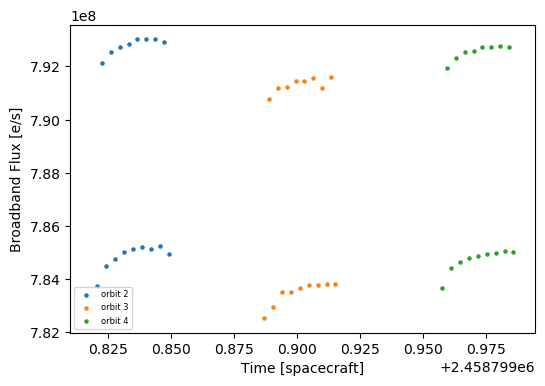

In [20]:
y1 = orbit1_broadbands
y2 = orbit2_broadbands
y3 = orbit3_broadbands
y4 = orbit4_broadbands
e1 = orbit1_broadbands_uncs
e2 = orbit2_broadbands_uncs
e3 = orbit3_broadbands_uncs
e4 = orbit4_broadbands_uncs
t1 = orbit1_times
t2 = orbit2_times
t3 = orbit3_times
t4 = orbit4_times
# x1 = np.arange(len(orbit1_broadbands))
# x2 = np.arange(len(orbit2_broadbands)) + x1[-1] + 1
# x3 = np.arange(len(orbit3_broadbands)) + x2[-1] + 1
# x4 = np.arange(len(orbit4_broadbands)) + x3[-1] + 1

fig, ax = plt.subplots(figsize=(6,4))
#plt.scatter(t1, y1, s=5, label='orbit 1')
plt.scatter(t2, y2, s=5, label='orbit 2')
plt.scatter(t3, y3, s=5, label='orbit 3')
plt.scatter(t4, y4, s=5, label='orbit 4')
plt.xlabel('Time [spacecraft]')
plt.ylabel('Broadband Flux [e/s]')
plt.legend(loc='best', fontsize=6)
plt.show()

In [21]:
meanflux1 = np.mean(y1)
meanerr1 = np.mean(e1)
meanflux2 = np.mean(y2)
meanerr2 = np.mean(e2)
meanflux3 = np.mean(y3)
meanerr3 = np.mean(e3)
meanflux4 = np.mean(y4)
meanerr4 = np.mean(e4)

print('Orbit 1')
print('Mean flux = %.1f'%(meanflux1))
print('Mean error = %.1f'%(meanerr1))
print('Relative error = %.3f percent'%(100.*meanerr1/meanflux1))
print('Orbit 2')
print('Mean flux = %.1f'%(meanflux2))
print('Mean error = %.1f'%(meanerr2))
print('Relative error = %.3f percent'%(100.*meanerr2/meanflux2))
print('Orbit 3')
print('Mean flux = %.1f'%(meanflux3))
print('Mean error = %.1f'%(meanerr3))
print('Relative error = %.3f percent'%(100.*meanerr3/meanflux3))
print('Orbit 4')
print('Mean flux = %.1f'%(meanflux4))
print('Mean error = %.1f'%(meanerr4))
print('Relative error = %.3f percent'%(100.*meanerr4/meanflux4))


Orbit 1
Mean flux = 787809451.2
Mean error = 28067.8
Relative error = 0.004 percent
Orbit 2
Mean flux = 788583087.3
Mean error = 28081.6
Relative error = 0.004 percent
Orbit 3
Mean flux = 787167304.8
Mean error = 28056.4
Relative error = 0.004 percent
Orbit 4
Mean flux = 788396616.2
Mean error = 28078.3
Relative error = 0.004 percent


## Normalizations

In [22]:
## Normalizing the broadband data
# I'll normalize by the median of the maxes of the out-of-transit orbits
# This way, the HST hook reaches a max of ~1 for both
normval1 = np.median([np.max(orbit2_broadbands[::2]), np.max(orbit4_broadbands[::2])])
normval2 = np.median([np.max(orbit2_broadbands[1::2]), np.max(orbit4_broadbands[1::2])])

no1 = np.copy(orbit1_broadbands)
eo1 = np.copy(orbit1_broadbands_uncs)
no1[::2] /= normval1
eo1[::2] /= normval1
no1[1::2] /= normval2
eo1[1::2] /= normval2
no2 = np.copy(orbit2_broadbands)
eo2 = np.copy(orbit2_broadbands_uncs)
no2[::2] /= normval1
eo2[::2] /= normval1
no2[1::2] /= normval2
eo2[1::2] /= normval2
no3 = np.copy(orbit3_broadbands)
eo3 = np.copy(orbit3_broadbands_uncs)
no3[::2] /= normval1
eo3[::2] /= normval1
no3[1::2] /= normval2
eo3[1::2] /= normval2
no4 = np.copy(orbit4_broadbands)
eo4 = np.copy(orbit4_broadbands_uncs)
no4[::2] /= normval1
eo4[::2] /= normval1
no4[1::2] /= normval2
eo4[1::2] /= normval2

In [23]:
#saveData = 
if saveData:
    datapath = '/home/mmmurphy/data/hd219666b/reduced_data/'
    np.savez(datapath+'orbit1_extractednormalizedbroadbanddata.npz', times=orbit1_times, broadbandflux=no1, broadbanderrs=eo1)
    np.savez(datapath+'orbit2_extractednormalizedbroadbanddata.npz', times=orbit2_times, broadbandflux=no2, broadbanderrs=eo2)
    np.savez(datapath+'orbit3_extractednormalizedbroadbanddata.npz', times=orbit3_times, broadbandflux=no3, broadbanderrs=eo3)
    np.savez(datapath+'orbit4_extractednormalizedbroadbanddata.npz', times=orbit4_times, broadbandflux=no4, broadbanderrs=eo4)
    print('Data Saved to directory: ', datapath)

Data Saved to directory:  /home/mmmurphy/data/hd219666b/reduced_data/


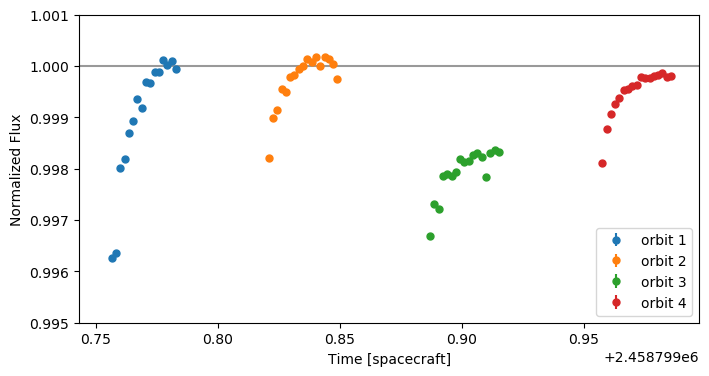

In [24]:
# Looking at the normalized broadband light curve
#    with each orbit labeled
fig, ax = plt.subplots(figsize=(8,4))
# plt.scatter(t1, no1, label='orbit 1')
# plt.scatter(t2, no2, label='orbit 2')
# plt.scatter(t3, no3, label='orbit 3')
# plt.scatter(t4, no4, label='orbit 4')
plt.errorbar(t1, no1, yerr=eo1, ls='None', marker='o', ms=5, label='orbit 1')
plt.errorbar(t2, no2, yerr=eo2, ls='None', marker='o', ms=5, label='orbit 2')
plt.errorbar(t3, no3, yerr=eo3, ls='None', marker='o', ms=5, label='orbit 3')
plt.errorbar(t4, no4, yerr=eo4, ls='None', marker='o', ms=5, label='orbit 4')
plt.axhline(1., c='black', alpha=0.4)
plt.ylim((0.995, 1.001))
plt.xlabel('Time [spacecraft]')
plt.ylabel('Normalized Flux')
plt.legend(loc='lower right')
plt.savefig('figures/normalized_broadband_lightcurve.png', dpi=400, bbox_inches='tight')
plt.show()